In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from glob import glob
from natsort import natsorted
import numpy as np

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Lambda
import torchvision.transforms.functional as TF
import pytorch_lightning as pl
from pytorch_lightning.logging import TestTubeLogger

from kitti_adapt.utils.data import VkittiImageDataSet

/opt/anaconda/miniconda3/envs/ai/lib/python3.7/site-packages/pytorch_lightning/core/decorators.py:13: UserWarning: data_loader decorator deprecated in 0.6.1. Will remove 0.8.0
  warnings.warn(w)


In [3]:
class DepthEstimator(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.__dict__.update(kwargs)

        self.batch_size = self.__dict__.get("batch_size", 1)
        self.learning_rate = self.__dict__.get("learning_rate", 1e-5)

        self.stem = torchvision.models.segmentation.fcn_resnet50(progress=True)
        self.stem.classifier[4] = torch.nn.Conv2d(
            512, 1, kernel_size=(1, 1), stride=(1, 1)
        )  # Replace last layer with 1-channel conv

    def forward(self, x):
        return self.stem(x)["out"]
    # =========================================
    # Vanilla PyTorch methods end here.
    # It's PyTorch Lightning from here on down.
    # =========================================

    def configure_optimizers(self):
        return [torch.optim.Adam(self.parameters(), lr=self.learning_rate)]

    def training_step(self, batch, batch_nb):
        rgb = batch["rgb"]
        depth = batch["depth"]
        pred = self.forward(rgb)
        loss = F.mse_loss(pred, depth)
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        rgb = batch["rgb"]
        depth = batch["depth"]
        pred = self.forward(rgb)
        loss = F.mse_loss(pred, depth)
        return {"val_loss": loss}

    def validation_end(self, outputs):
        # avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        # tensorboard_logs = {"val_loss": avg_loss}
        # return {"avg_loss": avg_loss, "log": tensorboard_logs}
        return {}

In [4]:
# Define transforms
transforms = {
    "rgb": Compose([
        Resize(224),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    "depth": Compose([
        Resize(224),
        ToTensor(),
        Lambda(lambda x: x.float() / 65535),
    ])
}

In [6]:
# Data
VKITTI_DIR = "../data/vkitti"
DATASET_LIMIT = 10
BATCH_SIZE = 2

train_dataset = VkittiImageDataSet(VKITTI_DIR, ("rgb", "depth"), transforms=transforms, limit=DATASET_LIMIT)
train_dataset[0]["depth"]
val_dataset = VkittiImageDataSet(VKITTI_DIR, ("rgb", "depth"), transforms=transforms, limit=DATASET_LIMIT)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)

Subset 'rgb' contains 10 files
Subset 'depth' contains 10 files
Found a total of 10 valid files.
Subset 'rgb' contains 10 files
Subset 'depth' contains 10 files
Found a total of 10 valid files.


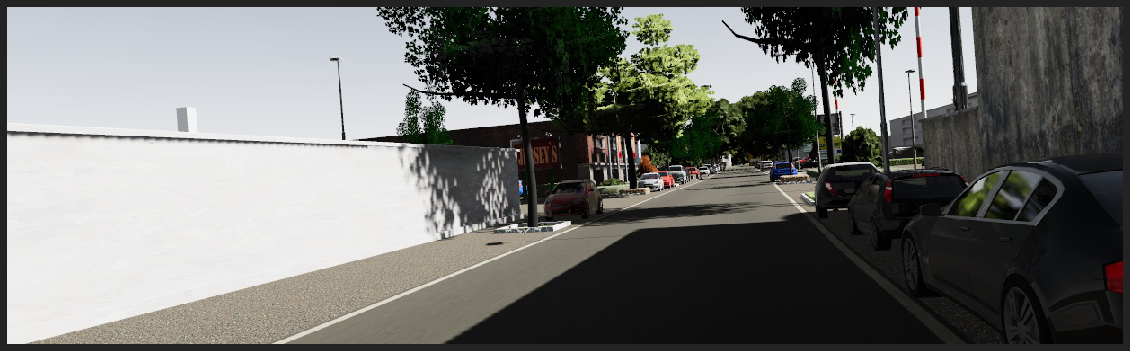

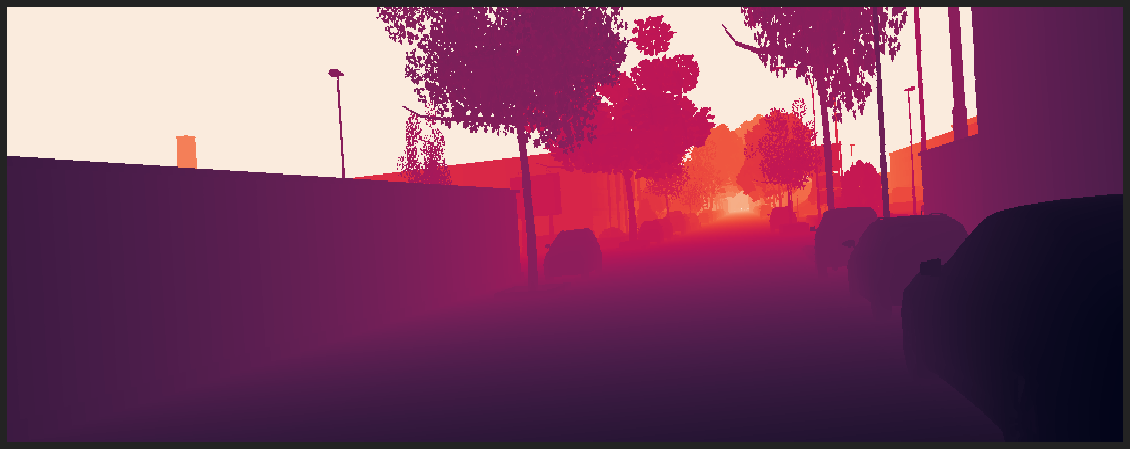

In [7]:
import matplotlib.colors as colors


def show_sample(rgb=None, depth=None):
    assert rgb is not None or depth is not None , "Can't show anything if there's nothing to show."
    if rgb is not None:
        plt.figure(figsize=(20, 8))
        plt.imshow(rgb)
        plt.axis('off')
        plt.show()
    if depth is not None:
        plt.figure(figsize=(20, 8))
#         depth = np.array(depth)
        sns.heatmap(depth, norm=colors.LogNorm(vmin=0, vmax=65535), cbar=False)
#         plt.imshow(depth)
        plt.axis('off')
        plt.show()
#         depth.show()

def tensor_to_depth(depth_tensor, as_pil=True):
    depth_tensor = depth_tensor * 65535
    out = TF.to_pil_image(depth_tensor, mode="I") if as_pil else depth_tensor.numpy()
    return out

def tensor_to_rgb(rgb_tensor, as_pil=True):
    out = TF.to_pil_image(rgb_tensor) if as_pil else rgb_tensor.numpy()
    return out

show_sample(**train_dataset.get(0))

In [ ]:
model = DepthEstimator()
print(model)
logger = TestTubeLogger(save_dir="experiments/")
trainer = pl.Trainer(progress_bar_refresh_rate=1, gpus=[0], logger=logger)
trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

DepthEstimator(
  (stem): FCN(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re

/opt/anaconda/miniconda3/envs/ai/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:147: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)
